In [1]:

import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
pkg = mp.jupyter.open_package()
pkg

In [3]:
df = pkg.resource('ps_extract').dataframe()

In [4]:
df.head()

,geoid,land_area,total_population,population_5_17,population_nh_white,population_college_degree,median_household_income,aggregate_household_income,average_agg_household_income,average_agg_house_value
0,14000US06073000100,0.595,2773,294,2276,1681,127353.0,283406300.0,220036.0,1005837.0
1,14000US06073000201,0.334,2158,140,1628,1139,98669.0,119734300.0,114798.0,389221.0
2,14000US06073000202,0.506,4828,449,3477,2474,61381.0,211142900.0,90542.0,270988.0
3,14000US06073000300,0.349,4946,111,3437,2676,63667.0,240566100.0,85733.0,175043.0
4,14000US06073000400,0.456,3916,194,2655,1881,67794.0,197192600.0,90705.0,120083.0


In [5]:
df['pop_density'] = df.total_population / df.land_area
df['hh_income_density'] = df.aggregate_household_income /  df.land_area
df['student_density'] = df.population_5_17 /  df.land_area

In [6]:
tracts = pkg.reference('tracts').geoframe()

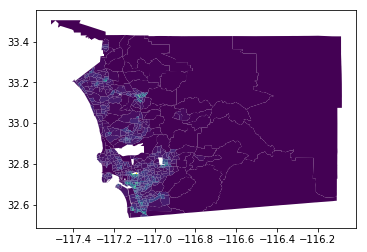

In [7]:
gdf = tracts.set_index('geoid').join(df.set_index('geoid'))
gdf.dropna().plot(column='student_density')

In [8]:
df.head().T

,0,1,2,3,4
geoid,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
land_area,0.595,0.334,0.506,0.349,0.456
total_population,2773,2158,4828,4946,3916
population_5_17,294,140,449,111,194
population_nh_white,2276,1628,3477,3437,2655
population_college_degree,1681,1139,2474,2676,1881
median_household_income,127353,98669,61381,63667,67794
aggregate_household_income,2.83406e+08,1.19734e+08,2.11143e+08,2.40566e+08,1.97193e+08
average_agg_household_income,220036,114798,90542,85733,90705
average_agg_house_value,1.00584e+06,389221,270988,175043,120083


In [9]:
gdf.to_csv('students.csv')

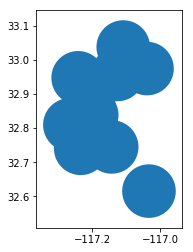

In [62]:
location_points = [
    ('Penasqutios', 32.957789, -117.125824),
    ('North Poway', 32.975030, -117.039214), 
    ('Bird Rock', 32.8096059823, -117.265816997),
    ('Otay', 32.6149830452, -117.033413607),
    ('Ocean Beach', 32.7407613478, -117.234059469),
    ('North Park', 32.7448502996, -117.142972308), 
    ('4S Del Norte', 33.0383246689, -117.10904655), # Black mountain, Camino Del Norte
    ('Carmel Valley', 32.947920, -117.241522),  
    ('UTC', 32.874481, -117.211164), # UTC
    ('PB Portal', 32.803410, -117.226234), #PB Portal
    ('North Clairemont', 32.838544, -117.201604) # North Clairemont
]

def one_mi_in_deg():
    from geopy.distance import lonlat, distance
    p1 = location_points[0][1:]
    return 1/((distance(p1, (p1[0],p1[1]+1)).miles + distance(p1, (p1[0]+1,p1[1])).miles )/2)



dist = 0.075 # About 5 miles in deg

locations_df = pd.DataFrame(location_points,columns='site_name lat lon'.split())

locations_df['id'] = locations_df.index

locations = gpd.GeoDataFrame(locations_df, geometry= [Point(x,y) for n,y,x in location_points ])

buffers = gpd.GeoDataFrame(locations, geometry = locations.buffer( one_mi_in_deg() * 5) )
buffers.crs = gdf.crs 
buffers.to_csv('/Users/eric/proj/virt-proj/planning/planning-database/datasets/sandiegodata.org-private_school/gis/sites.csv')
buffers.plot();


In [66]:
t1 = gpd.sjoin(gdf, buffers)
t1 = t1.groupby('site_name')['population_5_17','aggregate_household_income','total_population'].sum()
t1['pc_income'] = (t1.aggregate_household_income/ t1.total_population).round()
t2 = t1[['population_5_17', 'pc_income']].sort_values('pc_income', ascending=False)

enroll_frac = 285 / t2.loc['Carmel Valley'].population_5_17

t2['enrollable'] = (t2.population_5_17 * enroll_frac).round()
t2

,population_5_17,pc_income,enrollable
site_name,,,
Carmel Valley,30410,57340.0,285.0
UTC,39671,44004.0,372.0
Penasqutios,60965,43971.0,571.0
Bird Rock,22648,43337.0,212.0
North Poway,40354,43164.0,378.0
Ocean Beach,25983,43027.0,244.0
4S Del Norte,42869,42931.0,402.0
North Clairemont,37598,39770.0,352.0
PB Portal,38009,39535.0,356.0


In [72]:
enroll_frac

0.009371917132522197

In [78]:
t2[(t2.pc_income > 40000) ].sort_values('enrollable', ascending=False)[:5]

,population_5_17,pc_income,enrollable
site_name,,,
Penasqutios,60965,43971.0,571.0
4S Del Norte,42869,42931.0,402.0
North Poway,40354,43164.0,378.0
UTC,39671,44004.0,372.0
Carmel Valley,30410,57340.0,285.0


In [30]:
t1.head().T

,14000US06073990100,14000US06073017029,14000US06073008328,14000US06073008333,14000US06073008324
statefp,6,6,6,6,6
countyfp,73,73,73,73,73
tractce,990100,17029,8328,8333,8324
name_left,9901,170.29,83.28,83.33,83.24
namelsad,Census Tract 9901,Census Tract 170.29,Census Tract 83.28,Census Tract 83.33,Census Tract 83.24
mtfcc,G5020,G5020,G5020,G5020,G5020
funcstat,S,S,S,S,S
aland,0,30542211,7151963,15562234,5474223
awater,659396026,12376,0,0,42755
intptlat,32.9297,32.9909,32.9682,32.926,32.9516


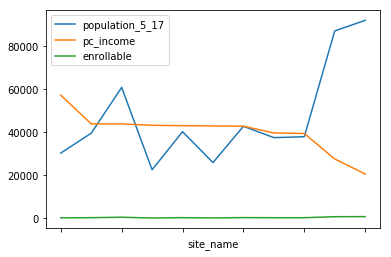